# Table of Contents
- Initializations
- EDA-Feature Engineering
  - Parsing and Calculating Helpfullnes Ratio
  - Visualizing Binned Distributions of Helpfullness Metrics
  - Boxplot of Ratings by Helpfulness Ratio Bins
  - Text Preprocessing for Review and Summary Fields
  - Sentiment Analysis on Reviews Using VADER
  - Sentiment Distribution of Reviews
  - Most Common WOrds in Positive, Negative, and Neutral Reviews
- Model Development
 - Loading Pretrained Sentence Transformer for Embedding
 - Calculating Laplace-Smoothing for Helpfullnes Ratio
 - Splitting Data
 - Hyperparameter Configuration for Various Machine Learning Models
 - Objective Function for Hyperparameter Tuning Using Optuna
 - Model Evaluation and Saving
- Model Training
  - Train and evaluate SVR
  - Train and evaluate LightGBM
  - Train and evaluate XGBoost
  - Train and evaluate CatBoost
  - Train and evaluate Random Forest
- Predictions on Test Set
  - SVR Prediction
  - XGBoost Prediction
  - LightGBM Prediction
  - CatBoost Prediction
  - Random Forest Prediction







  

# Initializations

In [ ]:
%pip install -q catboost
%pip install -q optuna
%pip install -q sentence-transformers
%pip install -q vaderSentiment

In [ ]:
import joblib
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import string
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostRegressor

from sentence_transformers import SentenceTransformer

import ast
from collections import Counter
import string

import optuna

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/BERT_rating_prediction/book_rating_20k.csv")
df.head(10)

,helpful,rating,reviewText,reviewTime,summary
0,19/27,1.0,This book is the worst of all the serie. And t...,NaN,The worst
1,"[0, 0]",5.0,"I don't write review but needed to say this, I...","06 13, 2013",worth reading
2,"[0, 1]",3.0,"This book was interesting, but to short and th...","12 26, 2013",Too short
3,"[0, 0]",5.0,I found the emotions in this book to be very i...,"03 19, 2014",Excellent book
4,6/6,2.0,"I read Robert Kiyosaki's book ""Rich Dad, Poor ...",NaN,Unrealistic Advice Awaits You!!
5,10/19,1.0,"Mr. Ward is listed on the book cover as a ""con...",NaN,"NOT History, but Editorial"
6,3/9,1.0,Emerson is one of the best of today's thriller...,NaN,What a disappointment!
7,"[0, 0]",3.0,During the wholes series I was and I am a fan ...,"03 8, 2014",Still a fan of DJ and her fear and strenght
8,11/11,5.0,A must-read for anyone mourning the death of a...,NaN,Fantastic!
9,"[3, 4]",2.0,None of the characters seemed believable to me...,"01 22, 2012",Not believable at all


# EDA - Feature Engineering

In [ ]:
# check for nan
df.isnull().sum()

,0
helpful,0
rating,0
reviewText,0
reviewTime,10400
summary,1


In [ ]:
# check for duplicate samples
df.duplicated().sum()

np.int64(77)

In [ ]:
df.dtypes

,0
helpful,object
rating,float64
reviewText,object
reviewTime,object
summary,object


### Parsing and Calculating Helpfulness Ratio

In [ ]:
def parse_helpful(value):
    try:

        if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
            parsed = ast.literal_eval(value)
            if isinstance(parsed, list) and len(parsed) == 2:
                return parsed[0], parsed[1]

        elif isinstance(value, str) and '/' in value:
            helpful_votes, total_votes = map(int, value.split('/'))
            return helpful_votes, total_votes
    except:
        pass
    return 0, 0

df[['helpful_votes', 'total_votes']] = df['helpful'].apply(
    lambda x: pd.Series(parse_helpful(x))
)

df['helpfulness_ratio'] = np.where(
    df['total_votes'] == 0,
    0,
    np.round(df['helpful_votes'] / df['total_votes'], 2)
)

df.drop('helpful', axis=1, inplace=True)

In [ ]:
df.head()

,rating,reviewText,reviewTime,summary,helpful_votes,total_votes,helpfulness_ratio
0,1.0,This book is the worst of all the serie. And t...,NaN,The worst,19,27,0.7
1,5.0,"I don't write review but needed to say this, I...","06 13, 2013",worth reading,0,0,0.0
2,3.0,"This book was interesting, but to short and th...","12 26, 2013",Too short,0,1,0.0
3,5.0,I found the emotions in this book to be very i...,"03 19, 2014",Excellent book,0,0,0.0
4,2.0,"I read Robert Kiyosaki's book ""Rich Dad, Poor ...",NaN,Unrealistic Advice Awaits You!!,6,6,1.0


### Visualizing Binned Distributions of Helpfulness *Metrics*

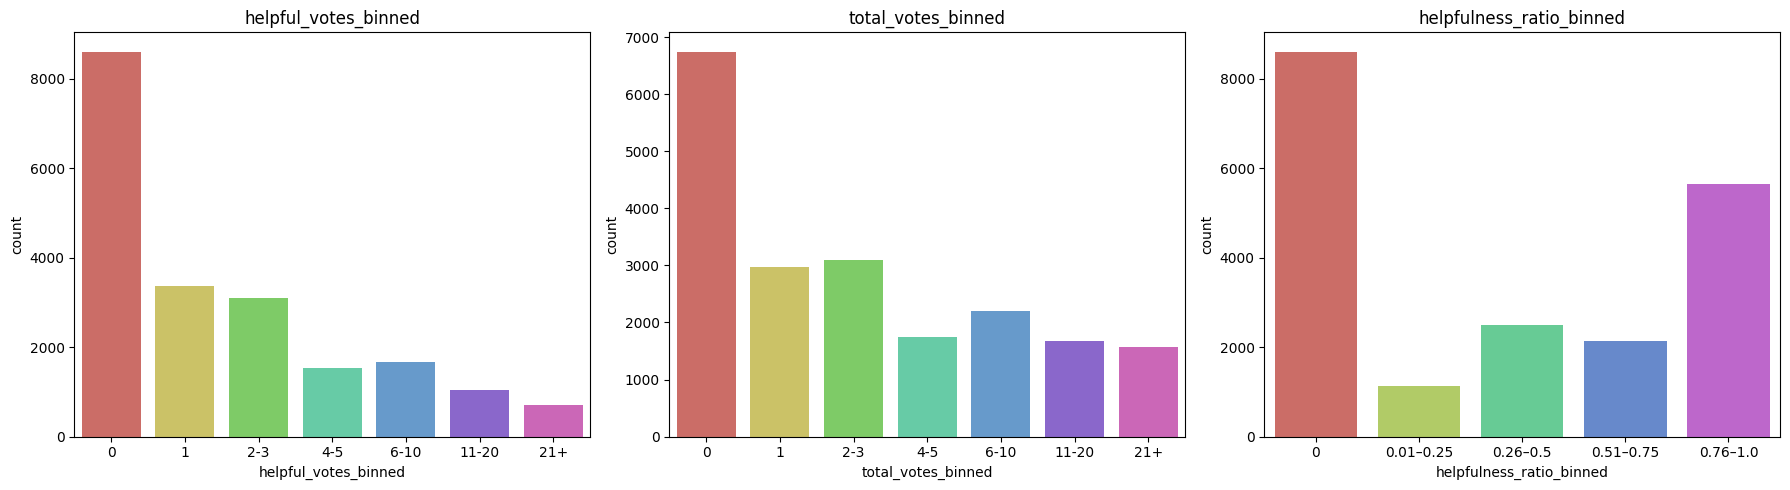

In [ ]:
df['helpful_votes_binned'] = pd.cut(df['helpful_votes'], bins=[-1, 0, 1, 3, 5, 10, 20, np.inf],
                                     labels=['0', '1', '2-3', '4-5', '6-10', '11-20', '21+'])

df['total_votes_binned'] = pd.cut(df['total_votes'], bins=[-1, 0, 1, 3, 5, 10, 20, np.inf],
                                   labels=['0', '1', '2-3', '4-5', '6-10', '11-20', '21+'])

df['helpfulness_ratio_binned'] = pd.cut(df['helpfulness_ratio'], bins=[-0.01, 0, 0.25, 0.5, 0.75, 1.0],
                                        labels=['0', '0.01–0.25', '0.26–0.5', '0.51–0.75', '0.76–1.0'])


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='helpful_votes_binned', hue="helpful_votes_binned", data=df, ax=axes[0], palette='hls')
axes[0].set_title("helpful_votes_binned")

sns.countplot(x='total_votes_binned', hue="total_votes_binned",data=df, ax=axes[1], palette='hls')
axes[1].set_title("total_votes_binned")

sns.countplot(x='helpfulness_ratio_binned', hue="helpfulness_ratio_binned", data=df, ax=axes[2], palette='hls')
axes[2].set_title("helpfulness_ratio_binned")

plt.tight_layout()
plt.show()

df.drop('helpful_votes_binned', axis=1, inplace=True)
df.drop('total_votes_binned', axis=1, inplace=True)
df.drop('helpfulness_ratio_binned', axis=1, inplace=True)

### Boxplot of Ratings by Helpfulness Ratio Bins

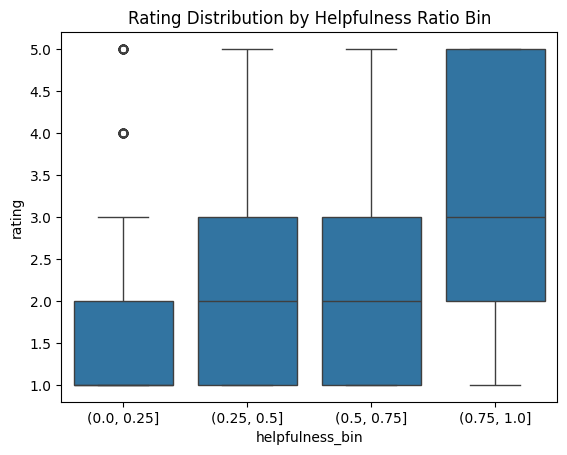

In [ ]:
df['helpfulness_bin'] = pd.cut(df['helpfulness_ratio'], bins=[0, 0.25, 0.5, 0.75, 1.0])
sns.boxplot(x='helpfulness_bin', y='rating', data=df)
plt.title("Rating Distribution by Helpfulness Ratio Bin")
plt.show()
df.drop("helpfulness_bin", axis=1, inplace=True)

In [ ]:
df.drop("reviewTime", axis=1, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

### Text Preprocessing for Review and Summary Fields

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = text.lower() # Convert all characters to lowercase
    text = text.strip() # Remove leading and trailing whitespace
    text = re.sub(r'https?://www.', '', text) # Remove URLs that start with 'http://www.' or 'https://www.'
    text = re.sub('\[.*?\]', '', text) # Remove content inside square brackets (e.g., [example])
    text = re.sub("\\W"," ",text) # Replace all non-word characters
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove remaining URLs
    text = re.sub('<.*?>+', '', text) # Remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    text = re.sub('\n', '', text) # Remove newline characters
    text = re.sub('\w*\d\w*', '', text) # Remove any word that contains digits
    return text


new_df = df.copy()
new_df['reviewText'] = new_df['reviewText'].apply(text_preprocessing)
new_df['summary'] = new_df['summary'].apply(text_preprocessing)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Sentiment Analysis on Reviews Using VADER

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(review):
    return analyzer.polarity_scores(review)

new_df['vader_scores'] = new_df['reviewText'].apply(get_sentiment)

new_df['compound'] = new_df['vader_scores'].apply(lambda score_dict: score_dict['compound'])

def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

new_df['sentiment'] = new_df['compound'].apply(classify_sentiment)

new_df.drop('vader_scores', axis=1, inplace=True)
new_df.drop('compound', axis=1, inplace=True)

new_df.head(10)

,rating,reviewText,summary,helpful_votes,total_votes,helpfulness_ratio,sentiment
0,1.0,This book is the worst of all the serie And t...,The worst,19,27,0.70,Negative
1,5.0,I don t write review but needed to say this I...,worth reading,0,0,0.00,Positive
2,3.0,This book was interesting but to short and th...,Too short,0,1,0.00,Positive
3,5.0,I found the emotions in this book to be very i...,Excellent book,0,0,0.00,Positive
4,2.0,I read Robert Kiyosaki s book Rich Dad Poor ...,Unrealistic Advice Awaits You,6,6,1.00,Positive
5,1.0,Mr Ward is listed on the book cover as a con...,NOT History but Editorial,10,19,0.53,Positive
6,1.0,Emerson is one of the best of today s thriller...,What a disappointment,3,9,0.33,Negative
7,3.0,During the wholes series I was and I am a fan ...,Still a fan of DJ and her fear and strenght,0,0,0.00,Positive
8,5.0,A must read for anyone mourning the death of a...,Fantastic,11,11,1.00,Positive
9,2.0,None of the characters seemed believable to me...,Not believable at all,3,4,0.75,Negative


### Sentiment Distribution of Reviews

<ipython-input-14-18c5f89cf6fc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_df, x='sentiment', palette='hls')


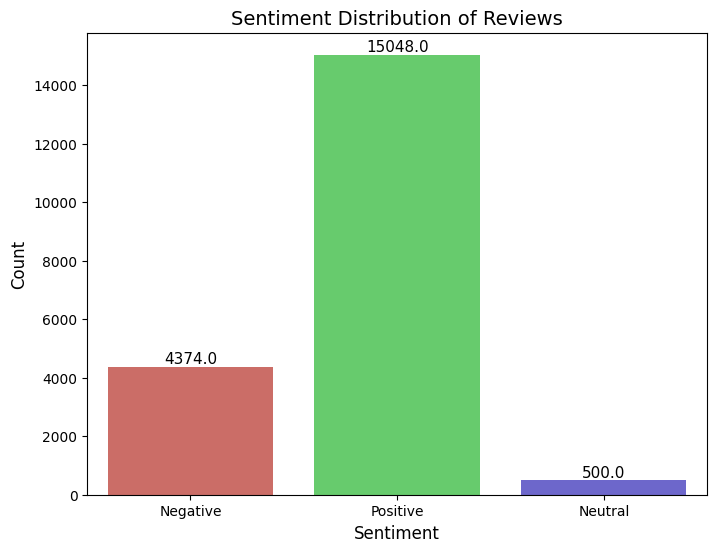

In [ ]:
plt.figure(figsize=(8, 6))

sns.countplot(data=new_df, x='sentiment', palette='hls')

plt.title('Sentiment Distribution of Reviews', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom', fontsize=11)

plt.show()

### Most Common Words in Positive, Negative, and Neutral Reviews

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-15-7197c3308ba2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette=color)


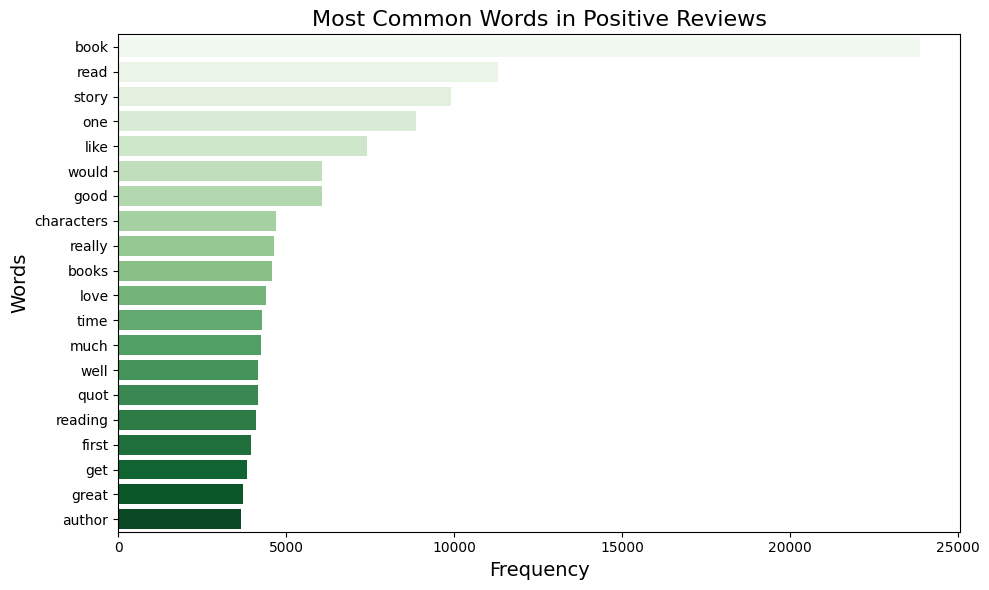

<ipython-input-15-7197c3308ba2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette=color)


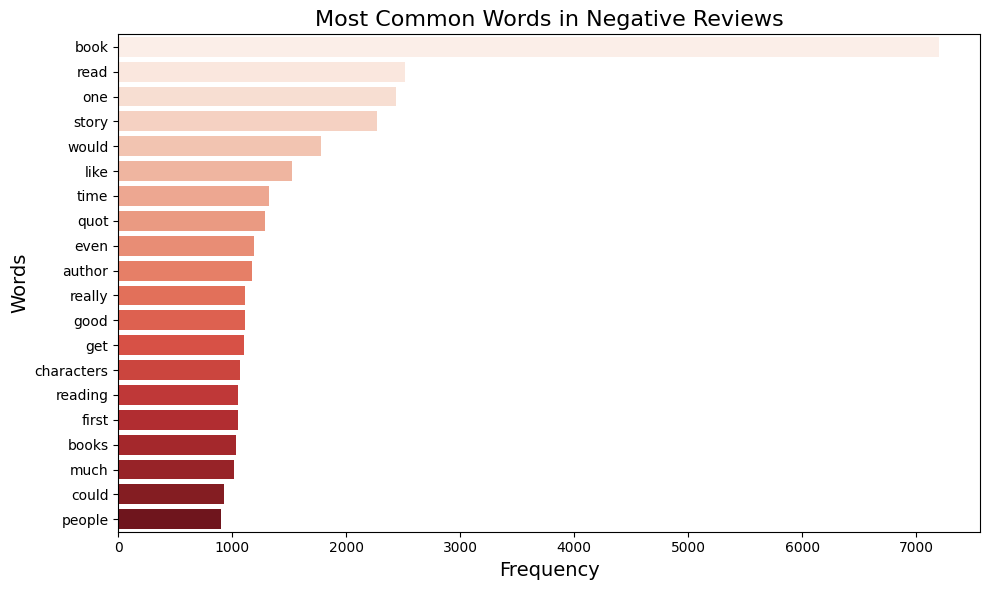

<ipython-input-15-7197c3308ba2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette=color)


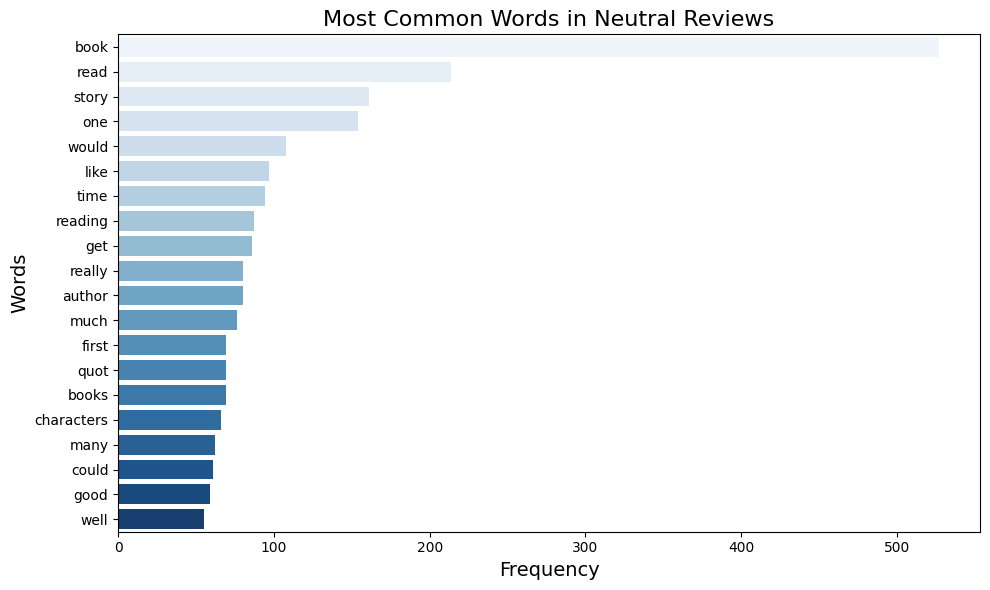

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def filter_tokens(tokens):
    return [token.lower() for token in tokens if token.lower() not in stop_words and token not in punctuation]

def plot_most_common_words(common_words, sentiment, color):
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette=color)

    plt.title(f'Most Common Words in {sentiment} Reviews', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.tight_layout()
    plt.show()

positive_reviews = new_df[new_df['sentiment'] == 'Positive']['reviewText']
negative_reviews = new_df[new_df['sentiment'] == 'Negative']['reviewText']
neutral_reviews  = new_df[new_df['sentiment'] == 'Neutral']['reviewText']

def get_filtered_words(text_series):
    words = []
    for review in text_series.dropna():
        tokens = review.split()
        filtered = filter_tokens(tokens)
        words.extend(filtered)
    return words

positive_words_list = get_filtered_words(positive_reviews)
negative_words_list = get_filtered_words(negative_reviews)
neutral_words_list  = get_filtered_words(neutral_reviews)

positive_words = Counter(positive_words_list).most_common(20)
negative_words = Counter(negative_words_list).most_common(20)
neutral_words  = Counter(neutral_words_list).most_common(20)

plot_most_common_words(positive_words, 'Positive', 'Greens')
plot_most_common_words(negative_words, 'Negative', 'Reds')
plot_most_common_words(neutral_words, 'Neutral', 'Blues')

In [ ]:
# I deleted "sentiment" because i realized it can mislead the model
new_df.drop("sentiment", axis=1, inplace=True)

# Model Development

### Loading Pretrained Sentence Transformer Model for Embedding

In [ ]:
# vectorization
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Calculating Laplace-Smoothing for Helpfulness Ratio

In [ ]:
α = 5
# global mean ratio (ignore zero-vote by replacing 0→nan)
μ = (
    new_df["helpful_votes"].sum()
    / new_df["total_votes"].replace(0, np.nan).sum()
)

# Laplace‐smoothed ratio
new_df["smoothed_ratio"] = (
    new_df["helpful_votes"] + α * μ
) / (
    new_df["total_votes"] + α
)

new_df.drop("helpful_votes", axis=1, inplace=True)
new_df.drop("total_votes", axis=1, inplace=True)
new_df.drop("helpfulness_ratio", axis=1, inplace=True)

new_df['text_combined'] = new_df['reviewText'] + " " + new_df['summary']

new_df.drop("summary", axis=1, inplace=True)
new_df.drop("reviewText", axis=1, inplace=True)

In [ ]:
new_df.head()

,rating,smoothed_ratio,text_combined
0,1.0,0.682661,This book is the worst of all the serie And t...
1,5.0,0.569032,I don t write review but needed to say this I...
2,3.0,0.474193,This book was interesting but to short and th...
3,5.0,0.569032,I found the emotions in this book to be very i...
4,2.0,0.804105,I read Robert Kiyosaki s book Rich Dad Poor ...


### Splitting Data

In [ ]:
train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=42, shuffle=True)
weights = train_df["smoothed_ratio"].values
train_df.drop("smoothed_ratio", axis=1, inplace=True)
test_df.drop("smoothed_ratio", axis=1, inplace=True)

### Hyperparameter Configuration for Various Machine Learning Models

In [ ]:
class CFG:
  cat_params = {
            'depth': (4, 10),
            'learning_rate': (0.01, 0.3),
            'l2_leaf_reg': (1, 15),
            'colsample_bylevel': (0.6, 1.0),
            'min_data_in_leaf': (1, 30),
            'grow_policy': (['SymmetricTree', 'Depthwise', 'Lossguide']),
            'bootstrap_type': (['Bayesian', 'Bernoulli', 'MVS']),
            'iterations': (800, 2000),
        }

  xgb_params = {
            'enable_categorical': True,
            'objective': 'reg:squarederror',
            'verbosity': 0,
            'n_estimators': (1000, 10000),
            'learning_rate': (1e-3, 0.1),
            'max_depth': (3, 8),
            'subsample': (0.5, 1.0),
            'colsample_bytree': (0.1, 1.0),
            'min_child_weight': (1, 100),
            'reg_lambda': (1e-2, 100.0)
        }

  seed = 42
  lgb_params = {
        'objective': 'regression',
        'metric': 'l2',
        'learning_rate': (1e-3, 0.2),
        'num_iterations': (100, 1000),
        'num_leaves': (16, 512),
        'max_depth': (3, 16),
        'min_child_samples': (5, 50),
        'reg_alpha': (1e-8, 10.0),
        'reg_lambda': (1e-8, 10.0),
        'extra_trees': ([True, False]),
        'importance_type': (['split', 'gain']),
        'max_bin': (128, 512),
        'verbose': -1
    }

  svr_params = {
        'C': (1e-1, 10.0),
        'epsilon': (1e-3, 10.0),
        'gamma': (['scale', 'auto']),
        'kernel': (['linear', 'poly', 'rbf', 'sigmoid'])
    }

  rf_params = {
      "n_estimators": (100, 1000),
      "max_depth": (10, 50),
      "min_samples_split": (2, 32),
      "min_samples_leaf": (1, 32),
      "max_features": (['sqrt', 'log2']),
      "criterion": ["squared_error"]
  }


### Objective Function for Hyperparameter Tuning Using Optuna

In [ ]:
def objective(trial, X, y, model_name, weights, n_splits=5):
  """
    Objective function for hyperparameter optimization using Optuna.
    It performs K-Fold cross-validation and calculates Mean Squared Error (MSE) for the given model.

    Parameters:
    - trial: The current Optuna trial, which contains hyperparameter suggestions.
    - X: The feature matrix (training data).
    - y: The target variable (training targets).
    - model_name: The name of the model (e.g., "CatBoost", "XGBoost", "LightGBM", "SVR", "RF").
    - weights: Sample weights for the training data.
    - n_splits: The number of splits for K-Fold cross-validation (default is 5).

    Returns:
    - The mean MSE score over the K-Fold splits. This will be minimized by Optuna to find the best hyperparameters.
    """

  X = np.array(X)
  y = np.array(y)
  weights = np.array(weights)
  print(f"\n----- Training {model_name} -----")

  cat_cols = [col for col in train_df.columns if train_df[col].dtype == ["category", "object"]]
  num_cols = [col for col in train_df.columns if train_df[col].dtype != ["category", "object"]]

  # K-Fold cross-validation
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  mse_scores = []

  for train_index, valid_index in kf.split(X):
      X_train, X_valid = X[train_index], X[valid_index]
      y_train, y_valid = y[train_index], y[valid_index]

      # Assigning sample weights for the training data
      sample_weights = weights[train_index]

      # Training and hyperparameter tuning for CatBoost
      if model_name.startswith("CatBoost"):
        params = {
            "loss_function": 'RMSE',
            'depth': trial.suggest_int('depth', *CFG.cat_params["depth"]),
            'learning_rate': trial.suggest_float('learning_rate', *CFG.cat_params["learning_rate"], log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', *CFG.cat_params["l2_leaf_reg"]),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', *CFG.cat_params["colsample_bylevel"]),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', *CFG.cat_params["min_data_in_leaf"]),
            'grow_policy': trial.suggest_categorical('grow_policy', CFG.cat_params["grow_policy"]),
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', CFG.cat_params["bootstrap_type"]),
            'iterations': trial.suggest_int('iterations', *CFG.cat_params["iterations"]),
        }

        model = CatBoostRegressor(
            **params,
            cat_features=cat_cols,
            verbose = 200
        )

      # Training and hyperparameter tuning for XGBoost
      if model_name.startswith("XGBoost"):
        params = {
            'enable_categorical': CFG.xgb_params["enable_categorical"],
            'objective': CFG.xgb_params['objective'],
            'verbosity': CFG.xgb_params["verbosity"],
            'n_estimators': trial.suggest_int("n_estimators", *CFG.xgb_params["n_estimators"]),
            'learning_rate': trial.suggest_loguniform("learning_rate", *CFG.xgb_params["learning_rate"]),
            'max_depth': trial.suggest_int("max_depth", *CFG.xgb_params["max_depth"]),
            'subsample': trial.suggest_float("subsample", *CFG.xgb_params["subsample"]),
            'colsample_bytree': trial.suggest_float("colsample_bytree", *CFG.xgb_params["colsample_bytree"]),
            'min_child_weight': trial.suggest_int("min_child_weight", *CFG.xgb_params["min_child_weight"]),
            'reg_lambda': trial.suggest_loguniform("reg_lambda", *CFG.xgb_params["reg_lambda"])
        }
        model = XGBRegressor(**params)

      # Training and hyperparameter tuning for LightGBM
      if model_name.startswith("LightGBM"):
        params = {
          'objective': 'regression',
          'metric': 'l2',
          'learning_rate': trial.suggest_float('learning_rate', *CFG.lgb_params['learning_rate'], log=True),
          'num_iterations': trial.suggest_int('num_iterations', *CFG.lgb_params['num_iterations']),
          'num_leaves': trial.suggest_int('num_leaves', *CFG.lgb_params['num_leaves']),
          'max_depth': trial.suggest_int('max_depth', *CFG.lgb_params['max_depth']),
          'min_child_samples': trial.suggest_int('min_child_samples', *CFG.lgb_params['min_child_samples']),
          'reg_alpha': trial.suggest_float('reg_alpha', *CFG.lgb_params['reg_alpha'], log=True),
          'reg_lambda': trial.suggest_float('reg_lambda', *CFG.lgb_params['reg_lambda'], log=True),
          'extra_trees': trial.suggest_categorical('extra_trees', CFG.lgb_params['extra_trees']),
          'importance_type': trial.suggest_categorical('importance_type', CFG.lgb_params['importance_type']),
          'max_bin': trial.suggest_int('max_bin', *CFG.lgb_params['max_bin']),
          'verbose': 200,
          'seed': CFG.seed
        }
        model = LGBMRegressor(**params)

      # Training and hyperparameter tuning for Support Vector Machine
      if model_name.startswith("SVR"):
        params = {
          'C': trial.suggest_float('C', *CFG.svr_params['C']),
          'epsilon': trial.suggest_float('epsilon', *CFG.svr_params['epsilon']),
          'gamma': trial.suggest_categorical('gamma', CFG.svr_params['gamma']),
          'kernel': trial.suggest_categorical('kernel', CFG.svr_params['kernel']),
        }
        model =  SVR(**params)

      # Training and hyperparameter tuning for Random Fores
      if model_name.startswith("RF"):
        params = {
          "n_estimators": trial.suggest_int('n_estimators', *CFG.rf_params["n_estimators"]),
          "max_depth": trial.suggest_int('max_depth', *CFG.rf_params["max_depth"]),
          "min_samples_split": trial.suggest_int('min_samples_split', *CFG.rf_params["min_samples_split"]),
          "min_samples_leaf": trial.suggest_int('min_samples_leaf', *CFG.rf_params["min_samples_leaf"]),
          "max_features": trial.suggest_categorical('max_features', CFG.rf_params["max_features"]),
          "criterion": trial.suggest_categorical('criterion', CFG.rf_params["criterion"]),
        }
        model = RandomForestRegressor(**params)

      # Fitting the model and making predictions
      model.fit(X_train, y_train, sample_weight=sample_weights)
      preds = model.predict(X_valid)

      # Calculating mean squared error
      mse = mean_squared_error(y_valid, preds)

      mse_scores.append(mse)

  return np.mean(mse_scores)

In [ ]:
train_embeddings = embedding_model.encode(list(train_df['text_combined'].values), show_progress_bar = True)
test_embeddings = embedding_model.encode(list(test_df['text_combined'].values), show_progress_bar = True)

X_train = train_embeddings
y_train = train_df['rating'].values

X_test = test_embeddings
y_test = test_df['rating'].values

def run(X_train, y_train, model_name, n_trials, weights):
  """
    Function to run hyperparameter optimization using Optuna.

    Parameters:
    - X_train: The training feature matrix
    - y_train: The training target values
    - model_name: The name of the model to use (e.g., CatBoost, XGBoost)
    - n_trials: The number of Optuna trials for optimization
    - weights: Sample weights for training

    Returns:
    - The best hyperparameters found by Optuna
    """

  study = optuna.create_study(direction="minimize")
  study.optimize(lambda trial: objective(trial, X_train, y_train, model_name, weights), n_trials=n_trials)

  print("Best MSE:", study.best_value)
  print("Best params:", study.best_params)

  return study.best_params

Batches:   0%|          | 0/499 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

### Model Evaluation and Saving

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, test_df, model_name):
    """
    This function evaluates a given machine learning model by training it on the training dataset,
    predicting on the test dataset, and calculating performance metrics. It also applies clipping and
    rounding on predictions to handle outliers and adjusts the results accordingly.

    Parameters:
    - model: The machine learning model to be evaluated (e.g., XGBoost, CatBoost, etc.)
    - X_train: Training features
    - y_train: Target values for the training set
    - X_test: Testing features
    - y_test: Target values for the test set
    - test_df: DataFrame that includes test data and will hold the predictions
    - model_name: The name of the model (string) for displaying results

    Returns:
    - test_df: The input DataFrame containing predictions and the evaluation metrics

    The function prints out the following evaluation metrics:
    - MAE (Mean Absolute Error)
    - MSE (Mean Squared Error)
    - R2 (R-squared)
    - Number of predictions greater than 5

    It then clips predictions that exceed a value of 5.0, rounds the predictions,
    and re-evaluates the model using the clipped and rounded predictions.
    """

    # Fit
    model.fit(X_train, y_train)

    # Predict
    preds = model.predict(X_test)
    test_df['preds'] = preds

    # Before clipping
    print(f"\n{model_name} Results (Before Clipping)")
    print("MAE:\t{:.5f}".format(mean_absolute_error(y_test, preds)))
    print("MSE:\t{:.5f}".format(mean_squared_error(y_test, preds)))
    print("R2:\t{:.5f}".format(r2_score(y_test, preds)))
    print("Preds > 5:\t", len(np.where(test_df['preds'] > 5)[0]))

    # Clipping predictions
    test_df['preds'] = test_df['preds'].apply(lambda x: 5.0 if x > 5.0 else x)

    # Rounding predictions
    test_df['preds'] = test_df['preds'].round()

    # After clipping
    print(f"\n{model_name} Results (After Clipping)")
    print("MAE:\t{:.5f}".format(mean_absolute_error(y_test, test_df['preds'])))
    print("MSE:\t{:.5f}".format(mean_squared_error(y_test, test_df['preds'])))
    print("R2:\t{:.5f}".format(r2_score(y_test, test_df['preds'])))

    return test_df

def save_model(model, model_name, output_dir="/content/drive/MyDrive/BERT_rating_prediction/ml_models/"):
    """
    This function saves a trained model to a specified directory in .pkl (pickle) format for later use.

    Parameters:
    - model: The trained machine learning model (e.g., XGBoost, CatBoost, etc.)
    - model_name: The name of the model to be saved (string)
    - output_dir: The directory where the model will be saved (string, default is '/content/drive/MyDrive/BERT_rating_prediction/ml_models/')

    Returns:
    - None

    The function creates the output directory (if it doesn't exist) and saves the model
    as a .pkl file using the provided model_name.
    """

    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, f"{model_name}.pkl")
    joblib.dump(model, file_path)
    print(f"Model saved to: {file_path}")

# Model Training

### Train and evaluate SVR

In [ ]:
best_params = run(X_train, y_train, model_name="SVR", n_trials=10, weights=weights)
best_model = SVR(**best_params)
test_df_svr = evaluate_model(best_model, X_train, y_train, X_test, y_test, test_df.copy(), "SVR")
save_model(best_model, "SVR")

[I 2025-05-05 01:29:27,584] A new study created in memory with name: no-name-52a7cbfc-9fba-47e7-8723-4b4f092f716b



----- Training SVR -----


[I 2025-05-05 01:29:28,047] Trial 0 finished with value: 2.008786794218514 and parameters: {'C': 1.6044469350355837, 'epsilon': 5.129898041235931, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 0 with value: 2.008786794218514.



----- Training SVR -----


[I 2025-05-05 01:29:28,428] Trial 1 finished with value: 2.008786794218514 and parameters: {'C': 6.950395858142592, 'epsilon': 8.263007510339525, 'gamma': 'auto', 'kernel': 'poly'}. Best is trial 0 with value: 2.008786794218514.



----- Training SVR -----


[I 2025-05-05 01:29:28,856] Trial 2 finished with value: 2.008786794218514 and parameters: {'C': 4.0329434090321445, 'epsilon': 6.710482040745274, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 0 with value: 2.008786794218514.



----- Training SVR -----


[I 2025-05-05 01:29:29,265] Trial 3 finished with value: 2.008786794218514 and parameters: {'C': 6.73292670503705, 'epsilon': 7.264923033411962, 'gamma': 'auto', 'kernel': 'poly'}. Best is trial 0 with value: 2.008786794218514.



----- Training SVR -----


[I 2025-05-05 01:29:29,897] Trial 4 finished with value: 2.008786794218514 and parameters: {'C': 3.307267337699071, 'epsilon': 2.1122197130373976, 'gamma': 'scale', 'kernel': 'linear'}. Best is trial 0 with value: 2.008786794218514.



----- Training SVR -----


[I 2025-05-05 01:29:30,575] Trial 5 finished with value: 2.008786794218514 and parameters: {'C': 4.176110246304359, 'epsilon': 9.132775547499957, 'gamma': 'scale', 'kernel': 'linear'}. Best is trial 0 with value: 2.008786794218514.



----- Training SVR -----


[I 2025-05-05 01:29:31,294] Trial 6 finished with value: 2.008786794218514 and parameters: {'C': 6.788976195955556, 'epsilon': 9.7142354107595, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 0 with value: 2.008786794218514.



----- Training SVR -----


[I 2025-05-05 01:29:31,893] Trial 7 finished with value: 2.008786794218514 and parameters: {'C': 0.9544234296362383, 'epsilon': 3.585254846189264, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 0 with value: 2.008786794218514.



----- Training SVR -----


[I 2025-05-05 01:40:55,123] Trial 8 finished with value: 0.7760451020243984 and parameters: {'C': 7.338960439730748, 'epsilon': 0.6723790114452726, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 8 with value: 0.7760451020243984.



----- Training SVR -----


[I 2025-05-05 01:40:55,777] Trial 9 finished with value: 2.008786794218514 and parameters: {'C': 1.4025900074852484, 'epsilon': 7.211523888919364, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 8 with value: 0.7760451020243984.


Best MSE: 0.7760451020243984
Best params: {'C': 7.338960439730748, 'epsilon': 0.6723790114452726, 'gamma': 'scale', 'kernel': 'rbf'}

SVR Results (Before Clipping)
MAE:	0.72293
MSE:	0.81285
R2:	0.58782
Preds > 5:	 53

SVR Results (After Clipping)
MAE:	0.68356
MSE:	0.90489
R2:	0.54115
Model saved to: /content/drive/MyDrive/BERT_rating_prediction/ml_models/SVR.pkl


### Train and evaluate LightGBM

In [ ]:
best_params = run(X_train, y_train, model_name="LightGBM", n_trials=1, weights=weights)
best_model = LGBMRegressor(**best_params, random_state=42)
test_df_lgb = evaluate_model(best_model, X_train, y_train, X_test, y_test, test_df.copy(), "LightGBM")
save_model(best_model, "LightGBM")

[I 2025-05-05 01:49:31,701] A new study created in memory with name: no-name-e87fe25d-b319-462f-94e0-c9f7d41407c7



----- Training LightGBM -----


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000036 seconds, init for row-wise cost 0.136174 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169728
[LightGBM] [Info] Number of data points in the train set: 12749, number of used features: 768
[LightGBM] [Info] Start training from score 3.089091
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000030 seconds, init for row-wise cost 0.159457 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169728
[LightGBM] [Info] Number of data points in the train set: 12749, number of used features: 768
[LightGBM] [Info] Start training from score 3.085546
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000025 seconds, init for row-wise cost 0.134938 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169728
[LightGBM] [Info] Number of data points in the train set: 12750, number of used features: 768
[LightGBM] [Info] Start training from score 3.072522
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000027 seconds, init for row-wise cost 0.141900 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169728
[LightGBM] [Info] Number of data points in the train set: 12750, number of used features: 768
[LightGBM] [Info] Start training from score 3.084268
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000026 seconds, init for row-wise cost 0.136931 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169728
[LightGBM] [Info] Number of data points in the train set: 12750, number of used features: 768
[LightGBM] [Info] Start training from score 3.060606
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-05 01:52:54,606] Trial 0 finished with value: 0.8748798310521527 and parameters: {'learning_rate': 0.07824601697326723, 'num_iterations': 505, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 22, 'reg_alpha': 0.3765869385615206, 'reg_lambda': 1.4193065941902772, 'extra_trees': True, 'importance_type': 'gain', 'max_bin': 221}. Best is trial 0 with value: 0.8748798310521527.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argum

Best MSE: 0.8748798310521527
Best params: {'learning_rate': 0.07824601697326723, 'num_iterations': 505, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 22, 'reg_alpha': 0.3765869385615206, 'reg_lambda': 1.4193065941902772, 'extra_trees': True, 'importance_type': 'gain', 'max_bin': 221}
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000023 seconds, init for row-wise cost 0.296389 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.378045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169728
[LightGBM] [Info] Number of data points in the train set: 15937, number of used features: 768
[LightGBM] [Info] Start training from score 2.999247
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 139 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Results (Before Clipping)
MAE:	0.76208
MSE:	0.90591
R2:	0.54064
Preds > 5:	 25

LightGBM Results (After Clipping)
MAE:	0.72271
MSE:	0.98018
R2:	0.50298
Model saved to: /content/drive/MyDrive/BERT_rating_prediction/ml_models/LightGBM.pkl


### Train and evaluate XGBoost

In [ ]:
best_params = run(X_train, y_train, model_name="XGBoost", n_trials=1, weights=weights)
best_model = XGBRegressor(**best_params, random_state=42)
test_df_xgb = evaluate_model(best_model, X_train, y_train, X_test, y_test, test_df.copy(), "XGBoost")
save_model(best_model, "XGBoost")

[I 2025-05-05 01:53:53,560] A new study created in memory with name: no-name-26a364f4-7123-4e28-99c8-16a76d6a47a4



----- Training XGBoost -----


<ipython-input-22-ec426803b024>:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", *CFG.xgb_params["learning_rate"]),
<ipython-input-22-ec426803b024>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform("reg_lambda", *CFG.xgb_params["reg_lambda"])
<ipython-input-22-ec426803b024>:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", *CFG.xgb_params["learning_rate"]),

Best MSE: 0.8214986310869181
Best params: {'n_estimators': 8894, 'learning_rate': 0.02174196702340082, 'max_depth': 8, 'subsample': 0.8723437430387672, 'colsample_bytree': 0.2668929521182326, 'min_child_weight': 48, 'reg_lambda': 66.71058230080637}

XGBoost Results (Before Clipping)
MAE:	0.74936
MSE:	0.86977
R2:	0.55896
Preds > 5:	 19

XGBoost Results (After Clipping)
MAE:	0.70841
MSE:	0.95182
R2:	0.51735
Model saved to: /content/drive/MyDrive/BERT_rating_prediction/ml_models/XGBoost.pkl


### Train and evaluate CatBoost

In [ ]:
best_params = run(X_train, y_train, model_name="CatBoost", n_trials=1, weights=weights)
best_model = CatBoostRegressor(**best_params, random_state=42, verbose=200, cat_features=[])
test_df_cat = evaluate_model(best_model, X_train, y_train, X_test, y_test, test_df.copy(), "CatBoost")
save_model(best_model, "CatBoost")

[I 2025-05-05 04:50:02,591] A new study created in memory with name: no-name-08e93d9b-7b66-4af8-a272-bdece09a8a52



----- Training CatBoost -----
0:	learn: 1.3878099	total: 432ms	remaining: 7m 55s
200:	learn: 0.8007912	total: 1m 28s	remaining: 6m 36s
400:	learn: 0.6515567	total: 2m 56s	remaining: 5m 8s
600:	learn: 0.5428019	total: 4m 24s	remaining: 3m 40s
800:	learn: 0.4564907	total: 5m 52s	remaining: 2m 12s
1000:	learn: 0.3879547	total: 7m 19s	remaining: 44.4s
1101:	learn: 0.3582108	total: 8m 3s	remaining: 0us
0:	learn: 1.3911417	total: 382ms	remaining: 7m
200:	learn: 0.8037437	total: 1m 29s	remaining: 6m 41s
400:	learn: 0.6529536	total: 2m 55s	remaining: 5m 7s
600:	learn: 0.5427884	total: 4m 22s	remaining: 3m 38s
800:	learn: 0.4575763	total: 5m 50s	remaining: 2m 11s
1000:	learn: 0.3884673	total: 7m 17s	remaining: 44.1s
1101:	learn: 0.3586188	total: 8m 1s	remaining: 0us
0:	learn: 1.3912326	total: 645ms	remaining: 11m 49s
200:	learn: 0.7995199	total: 1m 30s	remaining: 6m 44s
400:	learn: 0.6474191	total: 2m 56s	remaining: 5m 9s
600:	learn: 0.5414649	total: 4m 25s	remaining: 3m 41s
800:	learn: 0.4599

[I 2025-05-05 05:30:31,248] Trial 0 finished with value: 0.8627148672831615 and parameters: {'depth': 7, 'learning_rate': 0.05622527451238074, 'l2_leaf_reg': 2.4731161415461136, 'colsample_bylevel': 0.8114394815629717, 'min_data_in_leaf': 15, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'iterations': 1102}. Best is trial 0 with value: 0.8627148672831615.


1101:	learn: 0.3568983	total: 8m 8s	remaining: 0us
Best MSE: 0.8627148672831615
Best params: {'depth': 7, 'learning_rate': 0.05622527451238074, 'l2_leaf_reg': 2.4731161415461136, 'colsample_bylevel': 0.8114394815629717, 'min_data_in_leaf': 15, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'iterations': 1102}
0:	learn: 1.3961128	total: 389ms	remaining: 7m 8s
200:	learn: 0.8393792	total: 1m 32s	remaining: 6m 55s
400:	learn: 0.7010547	total: 3m 2s	remaining: 5m 18s
600:	learn: 0.5992386	total: 4m 32s	remaining: 3m 47s
800:	learn: 0.5167181	total: 6m 3s	remaining: 2m 16s
1000:	learn: 0.4494437	total: 7m 32s	remaining: 45.6s
1101:	learn: 0.4191679	total: 8m 17s	remaining: 0us

CatBoost Results (Before Clipping)
MAE:	0.75409
MSE:	0.89632
R2:	0.54549
Preds > 5:	 38

CatBoost Results (After Clipping)
MAE:	0.71568
MSE:	0.97616
R2:	0.50501
Model saved to: /content/drive/MyDrive/BERT_rating_prediction/ml_models/CatBoost.pkl


### Train and evaluate RandomForest

In [ ]:
best_params = run(X_train, y_train, model_name="RF", n_trials=1, weights=weights)
best_model = RandomForestRegressor(**best_params, random_state=42)
test_df_rf = evaluate_model(best_model, X_train, y_train, X_test, y_test, test_df.copy(), "RF")
save_model(best_model, "RandomForest")

[I 2025-05-05 05:38:50,070] A new study created in memory with name: no-name-8745ff38-59ff-4e68-9e6e-abf28eaca323



----- Training RF -----


[I 2025-05-05 06:05:36,834] Trial 0 finished with value: 1.1342462461663543 and parameters: {'n_estimators': 930, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'squared_error'}. Best is trial 0 with value: 1.1342462461663543.


Best MSE: 1.1342462461663543
Best params: {'n_estimators': 930, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'squared_error'}

RF Results (Before Clipping)
MAE:	0.88635
MSE:	1.12712
R2:	0.42846
Preds > 5:	 0

RF Results (After Clipping)
MAE:	0.87127
MSE:	1.24065
R2:	0.37089
Model saved to: /content/drive/MyDrive/BERT_rating_prediction/ml_models/RandomForest.pkl


# Predictions on Test Set

### SVR prediction

In [ ]:
test_df_svr.head(10)

,rating,text_combined,preds
18276,5.0,I think that this series is excellent and woul...,4.0
6961,4.0,It wasn t at all what I expected It was a fa...,2.0
4267,3.0,I love Tom Robbins I became a fan after readi...,4.0
10129,2.0,For my honor s english class we had to read t...,2.0
856,5.0,An emotional rollercoaster Cheering for both ...,5.0
7062,1.0,Slow tedious drawn out Might have been a ...,2.0
3618,2.0,Book is very generalized with little detail of...,2.0
15586,2.0,While I love this book and have reread it many...,3.0
7235,2.0,I like reading science fiction and I did want ...,2.0
2749,2.0,ALTHOUGH I AM A DIE HARD FAN OF JEFFERY AND HA...,3.0


### XGBoost prediction

In [ ]:
test_df_xgb.head(10)

,rating,text_combined,preds
18276,5.0,I think that this series is excellent and woul...,4.0
6961,4.0,It wasn t at all what I expected It was a fa...,2.0
4267,3.0,I love Tom Robbins I became a fan after readi...,3.0
10129,2.0,For my honor s english class we had to read t...,2.0
856,5.0,An emotional rollercoaster Cheering for both ...,4.0
7062,1.0,Slow tedious drawn out Might have been a ...,2.0
3618,2.0,Book is very generalized with little detail of...,3.0
15586,2.0,While I love this book and have reread it many...,2.0
7235,2.0,I like reading science fiction and I did want ...,2.0
2749,2.0,ALTHOUGH I AM A DIE HARD FAN OF JEFFERY AND HA...,3.0


### LightGBM prediction

In [ ]:
test_df_lgb.head(10)

,rating,text_combined,preds
18276,5.0,I think that this series is excellent and woul...,4.0
6961,4.0,It wasn t at all what I expected It was a fa...,2.0
4267,3.0,I love Tom Robbins I became a fan after readi...,3.0
10129,2.0,For my honor s english class we had to read t...,1.0
856,5.0,An emotional rollercoaster Cheering for both ...,5.0
7062,1.0,Slow tedious drawn out Might have been a ...,2.0
3618,2.0,Book is very generalized with little detail of...,2.0
15586,2.0,While I love this book and have reread it many...,2.0
7235,2.0,I like reading science fiction and I did want ...,2.0
2749,2.0,ALTHOUGH I AM A DIE HARD FAN OF JEFFERY AND HA...,3.0


### Catboost prediction

In [ ]:
test_df_cat.head(10)

,rating,text_combined,preds
18276,5.0,I think that this series is excellent and woul...,4.0
6961,4.0,It wasn t at all what I expected It was a fa...,2.0
4267,3.0,I love Tom Robbins I became a fan after readi...,3.0
10129,2.0,For my honor s english class we had to read t...,2.0
856,5.0,An emotional rollercoaster Cheering for both ...,5.0
7062,1.0,Slow tedious drawn out Might have been a ...,1.0
3618,2.0,Book is very generalized with little detail of...,2.0
15586,2.0,While I love this book and have reread it many...,2.0
7235,2.0,I like reading science fiction and I did want ...,2.0
2749,2.0,ALTHOUGH I AM A DIE HARD FAN OF JEFFERY AND HA...,3.0


### Random Forest prediction

In [ ]:
test_df_rf.head(10)

,rating,text_combined,preds
18276,5.0,I think that this series is excellent and woul...,4.0
6961,4.0,It wasn t at all what I expected It was a fa...,2.0
4267,3.0,I love Tom Robbins I became a fan after readi...,3.0
10129,2.0,For my honor s english class we had to read t...,2.0
856,5.0,An emotional rollercoaster Cheering for both ...,4.0
7062,1.0,Slow tedious drawn out Might have been a ...,2.0
3618,2.0,Book is very generalized with little detail of...,3.0
15586,2.0,While I love this book and have reread it many...,2.0
7235,2.0,I like reading science fiction and I did want ...,2.0
2749,2.0,ALTHOUGH I AM A DIE HARD FAN OF JEFFERY AND HA...,3.0
